<a href="https://colab.research.google.com/github/Tikquuss/GflowNets_Tutorial/blob/main/2_Hypergrid_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Author TODO

I thank Nikolay Malkin (author of [3]) for having answered my questions: it's thanks to his explanations that I was able to make this implementation, and it's also from his code that I was able to make mine.

In the  (hyper-)grid domain, the states are the cells of a n-dimensional hypercubic grid of side length $H$. The agent starts at coordinate $s = (0, 0, ..., 0)$ and is only allowed to increase coordinate $i$ (up to H, upon which the episode terminates). A stop action indicates to terminate the trajectory. There are many action sequences that lead to the same coordinate, making this Markov Decision Process a Directed Acyclic Graph. The reward for ending the trajectory in $s^\tau$ is some $R(s^\tau) > 0$.

In short, the nonterminal states form a n-dimensional hypergrid with side length $H$ : $\{ (s^0, ..., s^{n-1}) | s^i \in \{0, ..., H\}, 0 \leq i \leq n-1 \}$.



In each state $s = (s^0, ..., s^{n-1})$, we have $n+1$ possible actions:
- either choose a stop action and return the state as terminal, and the compute $R(s^\tau = s)$ 
- or we choose one of its $n$ coordinates, and increment it : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$


> Example : ndim=2 (H=2, ...)
```
|  ...   |   ...  | ...    | ...
................................
| (0, 2) | (1, 2) | (2, 2) | ...
................................
| (0, 1) | (1, 1) | (2, 1) | ...
................................
| (0, 0) | (1, 0) | (2, 0) | ...
................................
```

See below for an illustration of the reward function.

# Env

In [ ]:
import torch

def build_grid(ndim, H):
    """
    > Example : ndim=2 (H=2, ...)
    ```
    |  ...   |   ...  | ...    | ...
    ---------------------------------
    | (0, 2) | (1, 2) | (2, 2) | ...
    ---------------------------------
    | (0, 1) | (1, 1) | (2, 1) | ...
    ---------------------------------
    | (0, 0) | (1, 0) | (2, 0) | ...
    ---------------------------------
    ```
    """
    # We have (H+1)^ndim points, each point being of dimension ndim.
    grid_shape = (H+1,)*ndim+(ndim,) # (H+1, ..., H+1, ndim)
    grid = torch.zeros(grid_shape)
    for i in range(ndim):
        grid_i = torch.linspace(start=0, end=H, steps=H+1)
        for _ in range(i): grid_i = grid_i.unsqueeze(1)
        grid[...,i] = grid_i
    #return grid.view((H+1)**ndim,-1) # ((H+1)*ndim, ndim)
    return grid

## Reward function

$$R(x) = R_0 + R_1 \prod_{i=1}^{n} \mathbb{I} (0.25 < |x_i/H - 0.5|) + R_2 \prod_{i=1}^{n} \mathbb{I} (0.3 < |x_i/H - 0.5| < 0.4)$$

$$R_{cos}(x) = R_0 + R_1 \prod_{i=1}^{n} (cos(50x_i)+1) f_{\mathcal{N}} (5x_i) \text{, } R_0 = 0.01  \text{ and } f_{\mathcal{N}} \text{ is the normal p.d.f}$$

$$\dots$$

In [ ]:
import numpy as np
from scipy.stats import norm

def get_reward_function(H, R0, r_cos = False, R1 = 0.5, R2 = 2):
    """ 
    x ~ (bs, n), 0 < r0 << r1 < r2
    R1 : 1e-1, 1e-2, 1e-3 ...
    """
    def R(x) :
        ax = abs(x/H - 0.5)
        return R0 + (0.25 < ax).prod(-1) * R1  + ((0.3 < ax) * (ax < 0.4)).prod(-1) * R2
        #ax = abs(x/H*2 - 1)
        #return R0 + (0.5 < ax).prod(-1) * R1  + ((0.6 < ax) * (ax < 0.8)).prod(-1) * R2

    def R_cos(x) :
        ax = abs(x/H - 0.5)
        return R0 + ((np.cos(ax * 50) + 1) * norm.pdf(ax * 5)).prod(-1) * R1

    return R if not r_cos else R_cos

## sanity check

In [ ]:
R0, R1, R2 = 1e-2, 0.5, 2
R = get_reward_function(H=8, R0=R0, r_cos=False, R1=R1, R2=R2)
s_f = np.array([[4, 4], [0,0], [8, 8], [1,1]])
R(s_f) == np.array([R0, R0+R1, R0+R1, R0+R1+R2])

array([ True,  True,  True,  True])

In [ ]:
ndim, H = 2, 8
grid = build_grid(ndim, H)
grid, grid.shape

(tensor([[[0., 0.],
          [1., 0.],
          [2., 0.],
          [3., 0.],
          [4., 0.],
          [5., 0.],
          [6., 0.],
          [7., 0.],
          [8., 0.]],
 
         [[0., 1.],
          [1., 1.],
          [2., 1.],
          [3., 1.],
          [4., 1.],
          [5., 1.],
          [6., 1.],
          [7., 1.],
          [8., 1.]],
 
         [[0., 2.],
          [1., 2.],
          [2., 2.],
          [3., 2.],
          [4., 2.],
          [5., 2.],
          [6., 2.],
          [7., 2.],
          [8., 2.]],
 
         [[0., 3.],
          [1., 3.],
          [2., 3.],
          [3., 3.],
          [4., 3.],
          [5., 3.],
          [6., 3.],
          [7., 3.],
          [8., 3.]],
 
         [[0., 4.],
          [1., 4.],
          [2., 4.],
          [3., 4.],
          [4., 4.],
          [5., 4.],
          [6., 4.],
          [7., 4.],
          [8., 4.]],
 
         [[0., 5.],
          [1., 5.],
          [2., 5.],
          [3., 5.],
     

In [ ]:
R0, R1, R2 = 1e-2, 0.5, 2
R = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
all_rewards = R(grid)
all_rewards

tensor([[0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100]])

In [ ]:
true_dist = all_rewards.flatten().softmax(0).cpu().numpy()
true_dist

array([0.01234862, 0.01234862, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.01234862, 0.01234862, 0.01234862,
       0.09124463, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.09124463, 0.01234862, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.01234862, 0.09124463,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.09124463, 0.01234862, 0.01234862, 0.01234862, 0.00748

In [ ]:
grid.view((H+1)**ndim,-1)

tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [3., 0.],
        [4., 0.],
        [5., 0.],
        [6., 0.],
        [7., 0.],
        [8., 0.],
        [0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 1.],
        [6., 1.],
        [7., 1.],
        [8., 1.],
        [0., 2.],
        [1., 2.],
        [2., 2.],
        [3., 2.],
        [4., 2.],
        [5., 2.],
        [6., 2.],
        [7., 2.],
        [8., 2.],
        [0., 3.],
        [1., 3.],
        [2., 3.],
        [3., 3.],
        [4., 3.],
        [5., 3.],
        [6., 3.],
        [7., 3.],
        [8., 3.],
        [0., 4.],
        [1., 4.],
        [2., 4.],
        [3., 4.],
        [4., 4.],
        [5., 4.],
        [6., 4.],
        [7., 4.],
        [8., 4.],
        [0., 5.],
        [1., 5.],
        [2., 5.],
        [3., 5.],
        [4., 5.],
        [5., 5.],
        [6., 5.],
        [7., 5.],
        [8., 5.],
        [0., 6.],
        [1

## Plots



In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

def plot(x, y, z) :
    """https://stackoverflow.com/a/30539444/11814682"""
    xyz = {'x': x, 'y': y, 'z': z}
    # put the data into a pandas DataFrame (this is what my data looks like)
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 

    # re-create the 2D-arrays
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    #surf = ax.plot_surface(x2, y2, z2 / z.sum() - 1.5, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_zlim(-1.01, 1.01)

    ax.zaxis.set_major_locator(ticker.LinearLocator(10))
    ax.zaxis.set_major_formatter(ticker.FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('2D grid domain')

    plt.show()

In [ ]:
H = 4
N = 100
x, y = np.linspace(start = 0, stop = H, num=N), np.linspace(start = 0, stop = H, num=N)
xy = np.array(np.meshgrid(x, y)).T.reshape(-1,2) # (N*N,2)

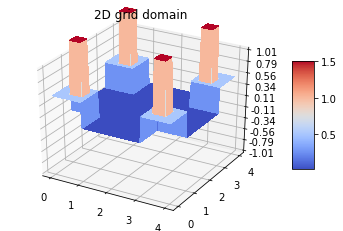

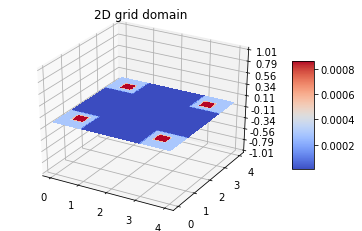

(None, None)

In [ ]:
R0, R1, R2 = 1e-2, 0.5, 1
R = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
z = R(xy)
x, y = xy[:,0], xy[:,1]
plot(x, y, z), plot(x, y, z / z.sum())#, plot(x, y, z / np.log(z))

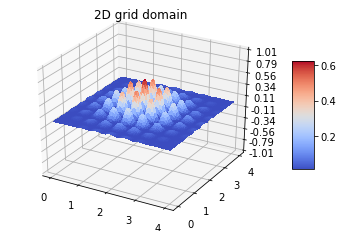

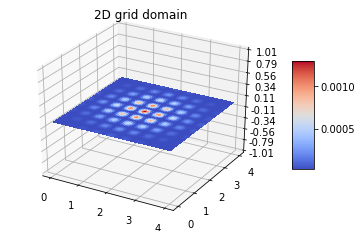

(None, None)

In [ ]:
R0, R1 = 1e-2, 1
R = get_reward_function(H=H, R0=R0, r_cos=True, R1=R1)
z = R(xy)
x, y = xy[:,0], xy[:,1]
plot(x, y, z), plot(x, y, z / z.sum())#, plot(x, y, z / np.log(z))

# Gflownet agents

In [ ]:
import torch
import numpy as np
import tqdm
import pickle

In [ ]:
H =  4 # horizon
#H =  8 # horizon
#H =  100 # horizon
ndim = 2
#ndim = 4
grid = build_grid(ndim, H) # (H, ...., H, ndim)
grid = grid.view((H+1)**ndim,-1) # ((H+1)**ndim, ndim)

R0, R1, R2 = 1e-2, 0.5, 2
reward_function = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
#R0, R1 = 1e-2, 1
#reward_function = get_reward_function(H, R0=R0, r_cos=True, R1=R1)

all_rewards = reward_function(grid)
#print('total reward', all_rewards.view(-1).logsumexp(0))
print('total reward', all_rewards.view(-1).sum(0))
true_dist = all_rewards.flatten().softmax(0).cpu().numpy()

total reward tensor(2.2500)




## For debugging

Once our model is trained, we will generate some terminal states, display their rewards and see if they match the figure below



In [ ]:
ar = all_rewards.reshape((H+1,)*ndim)

In [ ]:
if ndim == 2 :
  print(ar)

tensor([[0.5100, 0.0100, 0.0100, 0.0100, 0.5100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.5100, 0.0100, 0.0100, 0.0100, 0.5100]])


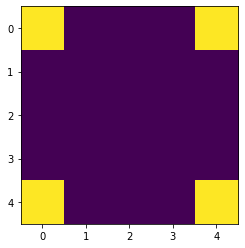

In [ ]:
if ndim == 2 :
    plt.imshow(ar)
else :
    plt.imshow(ar[0,0])

In [ ]:
if ndim == 4 :
    plt.imshow(ar.sum((0,1)),vmin=0);plt.show()

## Utils



In [ ]:
def make_mlp(l, act=torch.nn.LeakyReLU(), tail=[]):
    return torch.nn.Sequential(*(sum(
        [[torch.nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))



---
**Re-execute the following cells each time H changes**


In [ ]:
def one_hot_embedding(states, num_classes = H+1):
    # states : (bs, ndim) -> (bs, embedding_dim), embedding_dim = num_classes x ndim
    assert num_classes >= H + 1
    return torch.nn.functional.one_hot(states, num_classes).view(states.shape[0],-1).float()

The following function allows to associate a unique index to each state of the grid environment.\
Given that a coordinate can take $H+1$ values (from $0$ to $H$), it is enough to write them in this base to ensure the uniqueness.\
$$Index \bigg(s = (s_i)_{i=0}^{ndim-1} \bigg) = \sum_{i=0}^{ndim-1} s_i (H+1)^i $$
To find a state given its index, just invoke `grid[index]`

In [ ]:
base_coordinates = (H+1)**torch.arange(ndim) # [(H+1)^0, ..., (H+1)^(ndim-1)]

In [ ]:
def get_state_index(states):
    """
    This function allows to associate a unique index to each state of the grid environment.
    To find a state given its index, just invoke grid[state_index]
    > params : 
        * states ~ Tensor(num_states, ndim), batch_size can be zero (for single state)
    """
    state_index = (states*base_coordinates).sum().item()
    return state_index # (num_states,)

def get_state(indexes) :
    """
    This function allows to find a state given its index
    > params : 
        * indexes  ~ LongTensor(num_states,) or int (for single state)
    """
    return grid[indexes] # (num_states, ndim)

sanity check

In [ ]:
for i, states in enumerate(grid) :
    assert i == get_state_index(states)



---



In [ ]:
from typing import List

def get_modes_founds(first_visit : List[int], threshold : float = R2, max_steps : int = None) :
    """Calculates the modes (R >= threshold) found for each episode"""
    n = max_steps if max_steps is not None else n_train_steps
    xs = range(n)
    #modes_founds = [(reward_function(torch.stack([get_state(s) for s in list(set(np.where(first_visit == i)[0]))])) >= threshold).sum() for i in xs]
    
    # ((first_visit<np.arange(n_train_steps).unsqueeze(1)) - (first_visit==-1)) * batch_size
    # torch.from_numpy(first_visit) < torch.arange(n_train_steps).unsqueeze(1) & (torch.from_numpy(first_visit)!=-1)
    modes_founds = [0]*n
    for i in xs :
        states_i = list(set(np.where((0 <= first_visit) & (first_visit <= i))[0]))
        states_i = get_state(torch.LongTensor(states_i))
        r = reward_function(states_i)
        modes_founds[i] = (r >= threshold).sum().item()
    xs = [(i+1)*batch_size for i in xs]
    return modes_founds, xs

## Paramaters



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
n_hid = 256
n_layers = 2

batch_size = 128

inf = 1000000000
minus_inf = -inf

# set PB to uniform distribution (and learn just PF) or not 
uniform_PB = False

In [ ]:
#n_train_steps = 50000
#n_train_steps = 5000
n_train_steps = 1000
#n_train_steps = 50

## Trajectory Balance objective

$$ 
\mathcal{L}_{TB} \big(\tau = (s_0, ..., s_n = x) \big) = \bigg( log \frac{Z_{\theta} \prod_{t=1}^{n} P_{F} (s_t | s_{t-1}; \theta) }{R(x) \prod_{t=1}^{n} P_{B} (s_{t-1} | s_t; \theta) } \bigg)^2
\\= \bigg[ log(Z_{\theta}) + \sum_{t=1}^{n} \bigg( - log\big( P_{B} (s_{t-1} | s_t; \theta)\big) + log\big(P_{F} (s_t | s_{t-1}; \theta)\big) \bigg) - log \big(R(x)\big) \bigg]^2
$$

In [ ]:
input_dim = ndim*(H+1) # embedding dim
output_dim = 2*ndim+1 # ndim + 1 for P_F (+1 for stop action) and ndim for P_B 
model_TB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_TB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([ {'params':model_TB.parameters(), 'lr':0.001}, {'params':[logZ_TB], 'lr':0.1} ])
logZ_TB.requires_grad_()

model_TB

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
losses_TB = []
rewards_TB = []
logZ_TB_list = []
all_visited_TB = []
first_visit_TB = -1 * np.ones_like(true_dist)
l1log_TB = []

In [ ]:
for it in tqdm.trange(n_train_steps):
    
    # TB loss for each trajectory
    loss_TB = torch.zeros((batch_size,)).to(device)
    loss_TB += logZ_TB # see the equation above
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logits = model_TB(embed) # (current_batch_size, output_dim) 
        
        ### Backward Policy ### 
        PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
        PB_logits = PB_logits * (0 if uniform_PB else 1) # (current_batch_size, ndim)
        # Being in a edge cell -- (a zero coordinate), we can't move backward
        edge_mask = (non_terminal_states == 0).float() # (current_batch_size, ndim)
        logPB = (PB_logits + minus_inf*edge_mask).log_softmax(1) # (current_batch_size, ndim)
        # add -logPB to the loss
        if actions is not None: 
            """
            Gather along the parents' dimension (1) to select the logPB of the previously chosen actions, while avoiding the actions leading 
            to terminal states (action==ndim). The reason of using the previous chosen actions is that PB is calculated on the same trajectory as PF
            See below for the calculation of `action`. We avoid actions leading to terminal states because a terminal state can't be parent of another 
            state
            """
            loss_TB[~dones] -= logPB.gather(1, actions[actions != ndim].unsqueeze(1)).squeeze(1)

        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight = 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        # add logPF to the loss : gather along the children's dimension (1) to select the logPF for the chosen actions
        loss_TB[~dones] += logPF.gather(1, actions).squeeze(1)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_TB[state_index]<0: first_visit_TB[state_index] = it
            all_visited_TB.append(state_index)
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
        
    R = reward_function(states.float())
    loss_TB -= R.log()
    loss = (loss_TB**2).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_TB.append(loss.item())
    rewards_TB.append(R.mean().cpu())
    logZ_TB_list.append(logZ_TB.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_TB[-100:]).mean(), 'logZ =', logZ_TB.item(), "R =", np.array(rewards_TB[-100:]).mean())
        emp_dist = np.bincount(all_visited_TB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_TB.append((len(all_visited_TB), l1))

  1%|          | 6/1000 [00:00<00:33, 29.64it/s]


loss = 2.2698025703430176 logZ = -0.10000000149011612 R = 0.21312499
L1 = 0.03845068573951721


 11%|█         | 107/1000 [00:02<00:19, 46.83it/s]


loss = 0.34206743211252616 logZ = 0.7997243404388428 R = 0.43406242
L1 = 0.0483808496594429


 21%|██        | 206/1000 [00:04<00:16, 47.30it/s]


loss = 0.011511213357443921 logZ = 0.8064236640930176 R = 0.46589842
L1 = 0.05108918299277623


 30%|███       | 305/1000 [00:06<00:14, 49.28it/s]


loss = 0.00026650345961570565 logZ = 0.8110118508338928 R = 0.4651172
L1 = 0.051956431054791745


 41%|████      | 406/1000 [00:08<00:12, 47.52it/s]


loss = 7.092208709131853e-06 logZ = 0.8109246492385864 R = 0.4639453
L1 = 0.05234437833774715


 51%|█████     | 510/1000 [00:10<00:10, 48.43it/s]


loss = 6.453124629879348e-08 logZ = 0.8109281659126282 R = 0.46488282
L1 = 0.05260739656563053


 61%|██████    | 609/1000 [00:12<00:08, 48.73it/s]


loss = 3.355559935469543e-10 logZ = 0.8109304904937744 R = 0.46546876
L1 = 0.05279848693065756


 71%|███████   | 707/1000 [00:14<00:05, 49.02it/s]


loss = 1.174744468368516e-12 logZ = 0.8109301924705505 R = 0.46445313
L1 = 0.05291187676357985


 80%|████████  | 805/1000 [00:16<00:04, 44.18it/s]


loss = 4.274275378080006e-14 logZ = 0.8109302520751953 R = 0.4657422
L1 = 0.053022703592027175


 91%|█████████ | 906/1000 [00:18<00:01, 47.64it/s]


loss = 3.6618486021211536e-14 logZ = 0.8109302520751953 R = 0.46402344
L1 = 0.053078407928033366


100%|██████████| 1000/1000 [00:20<00:00, 48.85it/s]


### samples

In [ ]:
#model_TB, logZ_TB, losses_TB, rewards_TB, logZ_TB_list, all_visited_TB, first_visit_TB, l1log_TB = data["TB"]

In [ ]:
samples_TB = np.zeros((H+1,)*ndim)

In [ ]:
for it in tqdm.trange(500):
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logits = model_TB(embed) # (current_batch_size, output_dim) 
        
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight = 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        
        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        
        # Update dones
        dones[~dones] |= terminates
        
        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
    
    if ndim == 4 :
        for a,b,c,d in states: samples_TB[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_TB[a,b]+=1


100%|██████████| 500/500 [00:04<00:00, 124.79it/s]


In [ ]:
if ndim == 2 :
    print(samples_TB / samples_TB.sum())

[[0.22776562 0.00453125 0.00473437 0.00420313 0.22626562]
 [0.00403125 0.00426563 0.005125   0.00470312 0.00434375]
 [0.00423438 0.00457812 0.0044375  0.0041875  0.00398438]
 [0.0045     0.0043125  0.00470312 0.00442187 0.00484375]
 [0.228125   0.00465625 0.00425    0.00403125 0.22476562]]


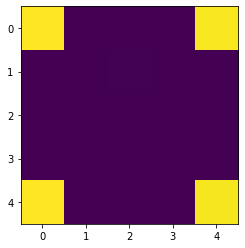

In [ ]:
if ndim == 2 :
    plt.imshow(samples_TB)
else :
    plt.imshow(samples_TB[0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_TB.sum((2,3))+samples_TB.sum((0,1))+samples_TB.sum((0,2))+samples_TB.sum((1,3))+samples_TB.sum((2,3))+samples_TB.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_TB.sum((1,3)),vmin=0);plt.show()

## Detailed balance objective

$$ 
\mathcal{L}_{DB} \big(s, s' \big) = \left\{
    \begin{array}{ll}
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta)}{R(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta) }{F_{\theta}(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{else.}
    \end{array}
\right. 
\\= \left\{
    \begin{array}{ll}
        \bigg[ log(F_{\theta} (s)) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) - log(R(s'))  \bigg]^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg[ log(F_{\theta} (s)) - log(F_{\theta} (s')) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) \bigg]^2 & \mbox{else.}
    \end{array}
\right. 
$$

In [ ]:
input_dim = ndim*(H+1) # embedding dim
output_dim = 2*ndim+2 # ndim + 1 for P_F (+1 for stop action), ndim for P_B, and 1 for F
model_DB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_DB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([{'params':model_DB.parameters(), 'lr':0.001}])

model_DB

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=6, bias=True)
)

In [ ]:
losses_DB = []
rewards_DB = []
logZ_DB_list = []
all_visited_DB = []
first_visit_DB = -1 * np.ones_like(true_dist)
l1log_DB = []

In [ ]:
for it in tqdm.trange(n_train_steps):
    
    # DB loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
    loss_DB = torch.zeros((batch_size, H+1+(ndim-1)*H)).to(device)
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    i = 0
    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logits = model_DB(embed) # (current_batch_size, output_dim) 

        ### logF ### 
        logF = logits[...,2*ndim+1] # (current_batch_size,)
        loss_DB[~dones,i] += logF # add logF(s_i) to the loss L(s_i, s_{i+1})
        if i>0: loss_DB[~dones,i-1] -= logF # add -logF(s_i) to the loss L(s_{i-1}, s_i)
        #else : logZ_DB[:] = logF.mean().item() # initial state : Z = F(s_0)
        else: logZ_DB[:] = logF[0].item() # initial state : Z = F(s_0)
        
        ### Backward Policy ### 
        PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
        PB_logits = PB_logits * (0 if uniform_PB else 1) # (current_batch_size, ndim)
        # Being in a edge cell -- (a zero coordinate), we can't move backward
        edge_mask = (non_terminal_states == 0).float() # (current_batch_size, ndim)
        logPB = (PB_logits + minus_inf*edge_mask).log_softmax(1) # (current_batch_size, ndim)
        # add -logPB(s_{i-1} | s_i) to the loss L(s_{i-1}, s_i)
        if actions is not None: 
            """
            Gather along the parents' dimension (1) to select the logPB of the previously chosen actions, while avoiding the actions leading 
            to terminal states (action==ndim). The reason of using the previous chosen actions () is that PB is calculated on the same trajectory as PF
            See below for the calculation of `action`. We avoid actions leading to terminal states because a terminal state can't be parent of another 
            state
            """
            loss_DB[~dones,i-1] -= logPB.gather(1, actions[actions!=ndim].unsqueeze(1)).squeeze(1)
    
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        # add logPF(s_i | s_{i+1}) to the loss L(s_i, s_{i+1}) : gather along the children's dimension (1) to select the logPF for the chosen actions
        loss_DB[~dones,i] += logPF.gather(1, actions).squeeze(1)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_DB[state_index]<0: first_visit_DB[state_index] = it
            all_visited_DB.append(state_index)

        # Add reward for terminal state
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        R_x = reward_function(non_terminal_states[terminates].float()) 
        loss_DB[termination_mask,i] -= (R_x + 1e-8).log()
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
            
        i += 1

    #lens = states.sum(1)+1 # number of actions taken for each trajectory
    #loss = (loss_DB**2).sum()/lens.sum() 
    loss = (loss_DB**2).sum(dim=1).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_DB.append(loss.item())
    R = reward_function(states.float())
    rewards_DB.append(R.mean().cpu())
    logZ_DB_list.append(logZ_DB.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_DB[-100:]).mean(), 'logZ =', logZ_DB.item(), "R =", np.array(rewards_DB[-100:]).mean())
        emp_dist = np.bincount(all_visited_DB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_DB.append((len(all_visited_DB), l1))

  1%|          | 8/1000 [00:00<00:28, 34.86it/s]


loss = 9.12228775024414 logZ = -0.07104812562465668 R = 0.20531249
L1 = 0.04220068573951721


 11%|█         | 108/1000 [00:02<00:22, 38.82it/s]


loss = 1.0561129689216613 logZ = 0.7790125608444214 R = 0.40871087
L1 = 0.04435238431290825


 21%|██        | 206/1000 [00:05<00:20, 38.72it/s]


loss = 0.024585392456501723 logZ = 0.8046982884407043 R = 0.46988282
L1 = 0.04938209344053743


 31%|███       | 309/1000 [00:08<00:17, 39.20it/s]


loss = 0.0009779528822582506 logZ = 0.8116322159767151 R = 0.46441406
L1 = 0.050779105473396396


 40%|████      | 405/1000 [00:10<00:16, 36.22it/s]


loss = 4.6449465805835644e-05 logZ = 0.8111069798469543 R = 0.4646875
L1 = 0.05149026362453018


 50%|█████     | 505/1000 [00:13<00:13, 38.04it/s]


loss = 1.0541541446684732e-05 logZ = 0.8108890652656555 R = 0.46316406
L1 = 0.05186887361153871


 60%|██████    | 605/1000 [00:15<00:10, 39.44it/s]


loss = 2.4391822803337957e-06 logZ = 0.810914933681488 R = 0.46113282
L1 = 0.052067413719343064


 71%|███████   | 709/1000 [00:18<00:07, 39.09it/s]


loss = 3.9745658129142216e-07 logZ = 0.8109490871429443 R = 0.46351564
L1 = 0.052263695593822365


 80%|████████  | 805/1000 [00:21<00:05, 37.87it/s]


loss = 5.1909804765770674e-08 logZ = 0.8109312653541565 R = 0.46488282
L1 = 0.05243827787417448


 90%|█████████ | 904/1000 [00:23<00:02, 33.13it/s]


loss = 5.717499766411116e-09 logZ = 0.8109309077262878 R = 0.4640625
L1 = 0.052559540003505045


100%|██████████| 1000/1000 [00:26<00:00, 38.06it/s]


### samples

In [ ]:
#model_DB, logZ_DB, losses_DB, rewards_DB, logZ_DB_list, all_visited_DB, first_visit_DB, l1log_DB = data["TB"]

In [ ]:
samples_DB = np.zeros((H+1,)*ndim)

In [ ]:
for it in tqdm.trange(500):
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logits = model_DB(embed) # (current_batch_size, output_dim) 
        
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)

        # Add reward for terminal state
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
            
    if ndim == 4 :
        for a,b,c,d in states: samples_DB[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_DB[a,b]+=1

100%|██████████| 500/500 [00:04<00:00, 121.81it/s]


In [ ]:
if ndim == 2 :
    print(samples_DB / samples_DB.sum())

[[0.22448438 0.0048125  0.0043125  0.00451562 0.22798437]
 [0.00460937 0.00451562 0.00498438 0.0045625  0.00475   ]
 [0.0045     0.00403125 0.00464062 0.00445312 0.0041875 ]
 [0.00407813 0.00454687 0.0043125  0.004      0.00489063]
 [0.22621875 0.00484375 0.00403125 0.00454687 0.2271875 ]]


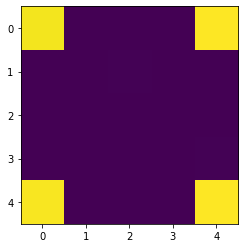

In [ ]:
if ndim == 2 :
    plt.imshow(samples_DB)
else :
    plt.imshow(samples_DB[0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_DB.sum((2,3))+samples_DB.sum((0,1))+samples_DB.sum((0,2))+samples_DB.sum((1,3))+samples_DB.sum((2,3))+samples_DB.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_DB.sum((1,3)),vmin=0);plt.show()

## Flow matching objective

$$
\mathcal{L}_{FM} \big(s\big) = \left\{
    \begin{array}{ll}
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta}^{log}(s'', s) \bigg) - log \bigg( \epsilon + R(s) \bigg) \bigg]^2 & \mbox{if } s \mbox{ terminal} \\
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta} ^{log}(s'', s) \bigg) - log \bigg( \epsilon +  \sum_{s \rightarrow s'} exp \text{ } F_{\theta}^{log}(s, s') \bigg) \bigg]^2 & \mbox{else (s non-initial)}
    \end{array}
\right. 
$$


In [ ]:
epsilon = all_rewards.min()
#epsilon = 1e-6
epsilon

tensor(0.0100)



---


The following functions allow, in a given state, to find all its parents, to evaluate the model on these parents, and to consider the flow from the parents to the current state.

In [ ]:
def get_parents(state) :
    """
    Return the parents of a given state, and the trasitions leading from the parents to the current state
    For `state = [3., 1.]`, `parents = [[2., 1.], [3., 0.]]` and `transitions = [0, 1]`
    """
    assert state.sum() != 0.
    parents, transitions = [], []
    np = 0
    for i in range(ndim) :
        sp = state + 0
        if sp[i] > 0 :
            sp[i] -= 1
            np += 1
            # if sp.max() == H: # can't have a terminal parent
            #     np -= 1
            #     continue
            parents.append(sp)
            transitions.append(i)
    if np == 0 : return None, None
    return torch.stack(parents), torch.LongTensor(transitions)

def get_inflow_old(state, model) :
    """Return the in flow of a given state"""
    parents, transitions = get_parents(state)
    embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
    logF = model(embed) # (n_parents, ndim+1)
    return logF.gather(1, transitions.unsqueeze(1).to(device)).exp().sum()

It is better to store the parents of each state to accelerate the training

In [ ]:
all_parents = {get_state_index(state.long()) : get_parents(state) for state in grid if state.sum() != 0.}

In [ ]:
def get_inflow(state, model, stop_action = False) :
    """Return the in flow of a given state"""
    if stop_action:
        #parents, transitions = state.unsqueeze(0), torch.LongTensor([ndim])         
        # Any state can be a parent of the terminal state : the corresponding action is always ndim
        parents = grid.clone()
        transitions = torch.LongTensor([ndim]*grid.size(0)) 
    else :
        state_id = get_state_index(state.long().cpu())
        parents, transitions = all_parents.get(state_id, (None, None))
    if parents is not None :
        embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
        logF = model(embed.to(device)) # (n_parents, ndim+1)
        return logF.gather(1, transitions.unsqueeze(1).to(device)).exp().sum()
    #else : return torch.tensor(0.)

In [ ]:
# for debugging
def parents_flow(non_terminal_states, actions, model):
    a = actions[actions!=ndim]
    parents = []
    print(non_terminal_states.shape, a.shape)
    print(non_terminal_states, actions)
    for n, i in zip(non_terminal_states, a) :
        s = n+0
        s[i]-=1
        parents.append(s)
    parents = torch.stack(parents)
    print(parents)
    embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
    logF = model(embed.to(device)) # (n_parents, ndim+1)
    return logF.gather(1, a.unsqueeze(1).to(device)).exp().sum(dim=1)



---



In [ ]:
input_dim = ndim*(H+1) # embedding dim
output_dim = ndim+1 # ndim + 1 for F (+1 for stop action)
model_FM = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_FM = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([{'params':model_FM.parameters(), 'lr':0.001}])

model_FM

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
losses_FM = []
rewards_FM = []
logZ_FM_list = []
all_visited_FM = []
first_visit_FM = -1 * np.ones_like(true_dist)
l1log_FM = []

In [ ]:
# #batch_size = 128
# #batch_size = 8
# #epsilon = 1e-2
# for it in tqdm.trange(n_train_steps): 
# #for it in tqdm.trange(1000):    
#     # FM loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
#     loss_FM = torch.zeros((batch_size, H+1+(ndim-1)*H +1)).to(device) # +1 for s_f
#     # finished trajectories
#     dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
#     # s_0
#     states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
#     # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
#     actions = None # (current_batch_size,)

#     current_batch_size = (~dones).sum()
#     non_terminal_states = states[~dones] # (current_batch_size, ndim)

#     i = 0
#     while True:
#         if actions is not None :
#             ### select terminals and non-terminal actions ### 
#             # non-terminals
#             terminates = (actions==ndim).squeeze(1)
#             termination_mask = ~dones
#             termination_mask[~dones] &= terminates
#             # terminals
#             non_terminates = (actions!=ndim).squeeze(1)
#             non_termination_mask = ~dones
#             non_termination_mask[~dones] &= non_terminates

#             ### In Flow : non-initial and non-terminal state ### 
#             if non_terminates.any(): 
#                 #inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states[non_terminates]]) # (current_batch_size,)
#                 #inFlow = torch.tensor(0.) if i==0 else parents_flow(non_terminal_states[non_terminates], actions, model_FM)
#                 inFlow = logPF.gather(1, actions[actions!=ndim].unsqueeze(1)).exp().sum(dim=1)
#                 loss_FM[non_termination_mask,i] += (epsilon + inFlow).log()  

#             ### In Flow : terminal state ###
#             if terminates.any():
#                 # add log_sumF(., s_i) to the loss L(s_i)   
#                 inFlow = torch.stack([get_inflow(state, model_FM, stop_action=True) for state in non_terminal_states[terminates]]) # (current_batch_size,)
#                 loss_FM[termination_mask,i] += (epsilon + inFlow).log() 

#             ### Out Flow for non-terminal states : add -log_sumF(s_i, .) to the loss L(s_i) ###
#             #outFlow = logF[non_terminates].exp().sum(dim=-1)
#             outFlow = logPF[non_terminates].exp().sum(dim=-1)
#             loss_FM[non_termination_mask,i] -= (epsilon + outFlow).log()

#             ### Out Flow for terminal states : Add -reward for terminal state ###
#             R_x = reward_function(non_terminal_states[terminates].float())
#             loss_FM[termination_mask,i] -= (epsilon + R_x).log()

#             ### select terminal states ### 
#             for state in non_terminal_states[terminates]: 
#                 state_index = get_state_index(state.cpu())
#                 if first_visit_FM[state_index]<0: first_visit_FM[state_index] = it
#                 all_visited_FM.append(state_index)

#             # Update dones
#             dones[~dones] |= terminates

#             # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
#             with torch.no_grad():
#                 non_terminates = actions[~terminates]
#                 states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

#             i += 1

#         if torch.any(~dones) :
#             ### Forward pass ### 
#             current_batch_size = (~dones).sum()
#             non_terminal_states = states[~dones] # (current_batch_size, ndim)
#             embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
#             logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

#             ### Forward Policy : tempered version of the state-action flow F ### 
#             # Being in a edge cell ++ (a coordinate that is H), we can't move forward
#             edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
#             # but any cell can be a terminal cell
#             stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
#             # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
#             PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
#             # logPF (with mask)
#             logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
#             # choose next states
#             sample_temperature = 1
#             #exp_weight= 0.
#             #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
#             PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
#             #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
#             #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
#             actions = PF.multinomial(1) # (current_batch_size,)
#         else :
#             break

#         if i==0 :
#             # initial state
#             #all_init_flow = logF.exp().sum(dim=1) # (current_batch_size,)
#             all_init_flow = logPF.exp().sum(dim=1) # (current_batch_size,)
#             #logZ_FM[:] = all_init_flow.mean().item() 
#             logZ_FM[:] = all_init_flow[0].item() # initial state)

#     loss_FM = loss_FM[:,1:] # remove L(s_0)
#     loss = (loss_FM**2).sum(dim=1).sum()/batch_size

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     losses_FM.append(loss.item())
#     R = reward_function(states.float())
#     rewards_FM.append(R.mean().cpu())
#     logZ_FM_list.append(logZ_FM.item())

#     if it%100==0: 
#         print('\nloss =', np.array(losses_FM[-100:]).mean(), 'logZ =', logZ_FM.item(), "R =", np.array(rewards_FM[-100:]).mean())
#         emp_dist = np.bincount(all_visited_FM[-200000:], minlength=len(true_dist)).astype(float)
#         emp_dist /= emp_dist.sum()
#         l1 = np.abs(true_dist-emp_dist).mean()
#         print('L1 =', l1)
#         l1log_FM.append((len(all_visited_FM), l1))

In [ ]:
for it in tqdm.trange(n_train_steps): 
#for it in tqdm.trange(100):    
    # FM loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
    loss_FM = torch.zeros((batch_size, H+1+(ndim-1)*H)).to(device)
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    i = 0
    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

        ### Forward Policy : tempered version of the state-action flow F ### 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = PF.multinomial(1) # (current_batch_size,)
        
        ### Out Flow for non-terminal states : add -log_sumF(s_i, .) to the loss L(s_i) ###
        non_terminates = (actions!=ndim).squeeze(1)
        termination_mask = ~dones
        termination_mask[~dones] &= non_terminates
        #outFlow = logF[non_terminates].exp().sum(dim=-1)
        outFlow = logPF[non_terminates].exp().sum(dim=-1)
        loss_FM[termination_mask,i] -= (epsilon + outFlow).log()

        ### In Flow : non-initial and non-terminal state ###
        if i!=0 :
            # add log_sumF(., s_i) to the loss L(s_i)
            #inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states]) # (current_batch_size,)
            #loss_FM[~dones,i] += (epsilon + inFlow).log()    
            if non_terminates.any(): 
                inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states[non_terminates]]) # (current_batch_size,)
                loss_FM[termination_mask,i] += (epsilon + inFlow).log()      
        else :
            # initial state
            #all_init_flow = logF.exp().sum(dim=1) # (current_batch_size,)
            all_init_flow = logPF.exp().sum(dim=1) # (current_batch_size,)
            #logZ_FM[:] = all_init_flow.mean().item() 
            logZ_FM[:] = all_init_flow[0].item() # initial state)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_FM[state_index]<0: first_visit_FM[state_index] = it
            all_visited_FM.append(state_index)

        # Add -reward for terminal state : Out Flow for terminal states
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        R_x = reward_function(non_terminal_states[terminates].float())
        loss_FM[termination_mask,i] -= (epsilon + R_x).log()

        ### In Flow : terminal state ###
        if i!=0 and terminates.any():
            # add log_sumF(., s_i) to the loss L(s_i)   
            inFlow = torch.stack([get_inflow(state, model_FM, stop_action=True) for state in non_terminal_states[terminates]]) # (current_batch_size,)
            #print(inFlow, "===========", non_terminal_states[terminates])
            loss_FM[termination_mask,i] += (epsilon + inFlow).log()           

        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

        i += 1
    
    loss_FM = loss_FM[:,1:] # remove L(s_0)
    loss = (loss_FM**2).sum(dim=1).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_FM.append(loss.item())
    R = reward_function(states.float())
    rewards_FM.append(R.mean().cpu())
    logZ_FM_list.append(logZ_FM.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_FM[-100:]).mean(), 'logZ =', logZ_FM.item(), "R =", np.array(rewards_FM[-100:]).mean())
        emp_dist = np.bincount(all_visited_FM[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_FM.append((len(all_visited_FM), l1))

  0%|          | 2/1000 [00:00<02:32,  6.54it/s]


loss = 30.88088607788086 logZ = 0.9999999403953552 R = 0.22484374
L1 = 0.03907568573951721


 10%|█         | 101/1000 [00:44<07:10,  2.09it/s]


loss = 4.355542334318161 logZ = 1.0 R = 0.4235546
L1 = 0.05721897769682478


 20%|██        | 201/1000 [01:30<06:05,  2.19it/s]


loss = 0.9859916377067566 logZ = 1.0 R = 0.45824218
L1 = 0.06120591183800009


 30%|███       | 301/1000 [02:22<06:39,  1.75it/s]


loss = 1.008434517979622 logZ = 0.9999999403953552 R = 0.456875
L1 = 0.06242121199832802


 40%|████      | 401/1000 [03:09<04:42,  2.12it/s]


loss = 0.9743653321266175 logZ = 0.9999999403953552 R = 0.45890626
L1 = 0.06320649960986396


 50%|█████     | 501/1000 [03:56<03:43,  2.23it/s]


loss = 1.0112667667865753 logZ = 1.0 R = 0.45679688
L1 = 0.06354855863396042


 60%|██████    | 601/1000 [04:43<03:02,  2.19it/s]


loss = 0.9885555344820023 logZ = 0.9999999403953552 R = 0.45824218
L1 = 0.06380486590294988


 70%|███████   | 701/1000 [05:30<02:20,  2.13it/s]


loss = 0.9919478964805603 logZ = 0.9999999403953552 R = 0.4580078
L1 = 0.06401122815938887


 80%|████████  | 801/1000 [06:17<01:37,  2.05it/s]


loss = 0.9993963533639908 logZ = 0.9999999403953552 R = 0.45773438
L1 = 0.06416216288613023


 90%|█████████ | 901/1000 [07:04<00:47,  2.09it/s]


loss = 0.9823740464448929 logZ = 0.9999999403953552 R = 0.45859376
L1 = 0.06429207991548172


100%|██████████| 1000/1000 [07:50<00:00,  2.12it/s]


In [ ]:
loss_FM[:,1:], loss_FM.shape

(tensor([[-1.6515e-03, -3.3549e-04, -2.0655e-05,  3.9067e-05, -8.5738e-04,
          -5.6446e-04, -3.2715e-01],
         [ 8.4741e-05, -6.2599e-04, -9.1254e-04, -3.8142e-04, -6.2103e-04,
          -4.8132e-04, -3.2715e-01],
         [ 8.4741e-05, -6.2599e-04, -9.1254e-04, -1.4837e-03, -6.5020e-04,
           2.9309e+00,  0.0000e+00],
         [-2.9863e-03, -6.2599e-04, -9.1254e-04, -3.8142e-04, -6.2103e-04,
          -4.8132e-04, -3.2715e-01],
         [ 8.4741e-05, -3.3549e-04, -9.1254e-04, -3.8142e-04, -6.5020e-04,
          -4.8132e-04, -3.2715e-01],
         [ 8.4741e-05, -6.2599e-04, -7.3902e-04, -3.8142e-04, -6.2103e-04,
          -4.8132e-04, -3.2715e-01],
         [ 8.4741e-05, -6.2599e-04, -7.3902e-04, -3.4612e-04, -6.2103e-04,
          -4.8132e-04, -3.2715e-01],
         [ 8.4741e-05, -6.2599e-04, -7.3902e-04, -3.4612e-04, -6.2103e-04,
          -4.8132e-04, -3.2715e-01],
         [ 8.4741e-05, -6.2599e-04, -9.1254e-04, -1.4837e-03, -6.5020e-04,
          -5.6446e-04, -3.271

In [ ]:
loss_FM[loss_FM != 0].shape

torch.Size([965])

### samples

In [ ]:
#model_FM, logZ_FM, losses_FM, rewards_FM, logZ_FM_list, all_visited_FM, first_visit_FM, l1log_FM = data["FM"]

In [ ]:
samples_FM = np.zeros((H+1,)*ndim)

In [ ]:
# #batch_size = 128
# #batch_size = 8
# #batch_size = 1
# epsilon = 1e-2
# for it in tqdm.trange(100):    
#     # finished trajectories
#     dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
#     # s_0
#     states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
#     # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
#     actions = None # (current_batch_size,)

#     current_batch_size = (~dones).sum()
#     non_terminal_states = states[~dones] # (current_batch_size, ndim)

#     i = 0
#     while torch.any(~dones):

#         if actions is not None :  
#             ### select terminal states ### 
#             terminates = (actions==ndim).squeeze(1)

#             # Update dones
#             dones[~dones] |= terminates

#             # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
#             with torch.no_grad():
#                 non_terminates = actions[~terminates]
#                 states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
#             i += 1

#         if torch.any(~dones) :
#             ### Forward pass ### 
#             current_batch_size = (~dones).sum()
#             non_terminal_states = states[~dones] # (current_batch_size, ndim)
#             embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
#             logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

#             ### Forward Policy : tempered version of the state-action flow F ### 
#             # Being in a edge cell ++ (a coordinate that is H), we can't move forward
#             edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
#             # but any cell can be a terminal cell
#             stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
#             # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
#             PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
#             # logPF (with mask)
#             logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
#             # choose next states
#             sample_temperature = 1
#             #exp_weight= 0.
#             #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
#             PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
#             #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
#             #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
#             actions = PF.multinomial(1) # (current_batch_size,)
#         else :
#             break

#     if ndim == 4 :
#         for a,b,c,d in states: samples_FM[a,b,c,d]+=1
#     elif ndim == 2 :
#         for a,b in states: samples_FM[a,b]+=1

In [ ]:
for it in tqdm.trange(500):    
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

        ### Forward Policy : tempered version of the flow F ### 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = PF.multinomial(1) # (current_batch_size,)
        
        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)

        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    if ndim == 4 :
        for a,b,c,d in states: samples_FM[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_FM[a,b]+=1

100%|██████████| 500/500 [00:04<00:00, 104.19it/s]


In [ ]:
if ndim == 2 :
    print(samples_FM / samples_FM.sum())

[[0.01278125 0.00454687 0.00245313 0.00315625 0.00675   ]
 [0.00754687 0.00495313 0.00329687 0.00345313 0.01084375]
 [0.0020625  0.00176563 0.00220312 0.00320312 0.00860938]
 [0.00232812 0.00215625 0.002375   0.00432813 0.01721875]
 [0.00375    0.00409375 0.00625    0.01317187 0.86670313]]


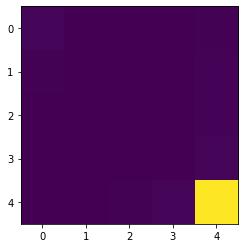

In [ ]:
if ndim == 2 :
    plt.imshow(samples_FM)
else :
    plt.imshow(samples_FM[0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_FM.sum((2,3))+samples_FM.sum((0,1))+samples_FM.sum((0,2))+samples_FM.sum((1,3))+samples_FM.sum((2,3))+samples_FM.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_FM.sum((1,3)),vmin=0);plt.show()

**This implementation has a problem. Refer to this official implementation for the moment : https://github.com/GFNOrg/gflownet**

## Random (uniform) agent

In [ ]:
rewards_random = []
all_visited_random = []
first_visit_random = -1 * np.ones_like(true_dist)
l1log_random = []

In [ ]:
for it in tqdm.trange(n_train_steps):

    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)

    while torch.any(~dones) : #and i <= max_length_traj :
        # Forward pass
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        
        ### Uniform Forward Policy ### 
        PF_logits = torch.ones(current_batch_size, ndim+1).to(device) # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # PF (with mask)
        PF = (PF_logits + minus_inf*PF_mask).softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        #actions = torch.from_numpy(np.random.choice(np.arange(ndim+1), size=(current_batch_size,1), p = PF))
        actions = PF.multinomial(1)
        #if i == max_length_traj : actions = torch.LongTensor(current_batch_size,1).fill_(ndim)
        # select terminal states
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_random[state_index]<0: first_visit_random[state_index] = it
            all_visited_random.append(state_index)
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    R = reward_function(states.float())
    rewards_random.append(R.mean().cpu())
    if it%100==0: 
        print("\nR =", np.array(rewards_random[-100:]).mean())
        emp_dist = np.bincount(all_visited_random[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_random.append((len(all_visited_random), l1))

  4%|▎         | 37/1000 [00:00<00:05, 186.85it/s]


R = 0.17796874
L1 = 0.03492659747600555


 13%|█▎        | 130/1000 [00:00<00:04, 178.29it/s]


R = 0.19171876
L1 = 0.03716041756738531


 23%|██▎       | 226/1000 [00:01<00:04, 183.70it/s]


R = 0.19402343
L1 = 0.037368596187278405


 32%|███▏      | 324/1000 [00:01<00:03, 189.75it/s]


R = 0.1913672
L1 = 0.03718573368863014


 42%|████▏     | 423/1000 [00:02<00:03, 188.86it/s]


R = 0.1946875
L1 = 0.0371180797544798


 54%|█████▍    | 539/1000 [00:02<00:02, 188.32it/s]


R = 0.19429688
L1 = 0.03715713639816124


 64%|██████▎   | 636/1000 [00:03<00:01, 184.99it/s]


R = 0.1928125
L1 = 0.03721757085370938


 73%|███████▎  | 732/1000 [00:03<00:01, 185.55it/s]


R = 0.19332032
L1 = 0.03719211102807403


 83%|████████▎ | 829/1000 [00:04<00:00, 187.70it/s]


R = 0.1946875
L1 = 0.03723230908649245


 92%|█████████▎| 925/1000 [00:05<00:00, 184.68it/s]


R = 0.1920703
L1 = 0.03718797372461821


100%|██████████| 1000/1000 [00:05<00:00, 184.62it/s]


### samples

In [ ]:
samples_random = np.zeros((H+1,)*ndim)

In [ ]:
for it in tqdm.trange(500):

    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)

    while torch.any(~dones) : #and i <= max_length_traj :
        # Forward pass
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        
        ### Uniform Forward Policy ### 
        PF_logits = torch.ones(current_batch_size, ndim+1).to(device) # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # PF (with mask)
        PF = (PF_logits + minus_inf*PF_mask).softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        #actions = torch.from_numpy(np.random.choice(np.arange(ndim+1), size=(current_batch_size,1), p = PF))
        actions = PF.multinomial(1)
        #if i == max_length_traj : actions = torch.LongTensor(current_batch_size,1).fill_(ndim)
        # select terminal states
        terminates = (actions==ndim).squeeze(1)
 
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    if ndim == 4 :
        for a,b,c,d in states: samples_random[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_random[a,b]+=1

100%|██████████| 500/500 [00:01<00:00, 250.32it/s]


In [ ]:
if ndim == 2 :
    print(samples_random / samples_random.sum())

[[0.33190625 0.11071875 0.03601563 0.01239063 0.00626563]
 [0.11278125 0.0754375  0.03742188 0.016125   0.0108125 ]
 [0.03798438 0.03692187 0.02457812 0.01328125 0.01315625]
 [0.01196875 0.01660937 0.014      0.00876563 0.01084375]
 [0.00614063 0.01135937 0.01223438 0.01085937 0.02142187]]


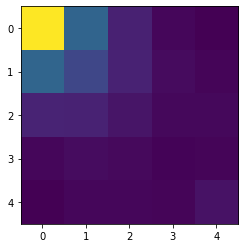

In [ ]:
if ndim == 2 :
    plt.imshow(samples_random)
else :
    plt.imshow(samples_random[0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_random.sum((2,3))+samples_random.sum((0,1))+samples_random.sum((0,2))+samples_random.sum((1,3))+samples_random.sum((2,3))+samples_random.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_random.sum((1,3)),vmin=0);plt.show()

## Saves models

In [ ]:
data = {
    "TB" : [model_TB, logZ_TB, losses_TB, rewards_TB, logZ_TB_list, all_visited_TB, first_visit_TB, l1log_TB],
    "DB" : [model_DB, logZ_DB, losses_DB, rewards_DB, logZ_DB_list, all_visited_DB, first_visit_DB, l1log_DB],
    "FM" : [model_FM, logZ_FM, losses_FM, rewards_FM, logZ_FM_list, all_visited_FM, first_visit_FM, l1log_FM],
    "random" : [None, None, None, rewards_random, None, all_visited_random, first_visit_random, l1log_random],
}

torch.save(data, "/content/data_gfn.pth")

## Plot

'\nxs = list(range(len(emp_loss_TB)))\nax4.plot(xs, emp_loss_TB, label="TB")\n#-\nxs = list(range(len(emp_loss_DB)))\nax4.plot(xs, emp_loss_DB, label="DB")\n#-\nxs = list(range(len(emp_loss_FM)))\nax4.plot(xs, emp_loss_FM, label="FM")\n#-\nxs = list(range(len(emp_loss_random)))\nax4.plot(xs, emp_loss_random, label="rand")\n#-\nax4.set(xlabel=\'#states visited\', ylabel=\'empirical loss\')\nax4.set_title(\'empirical loss per epoch\')\nax4.legend()\n'

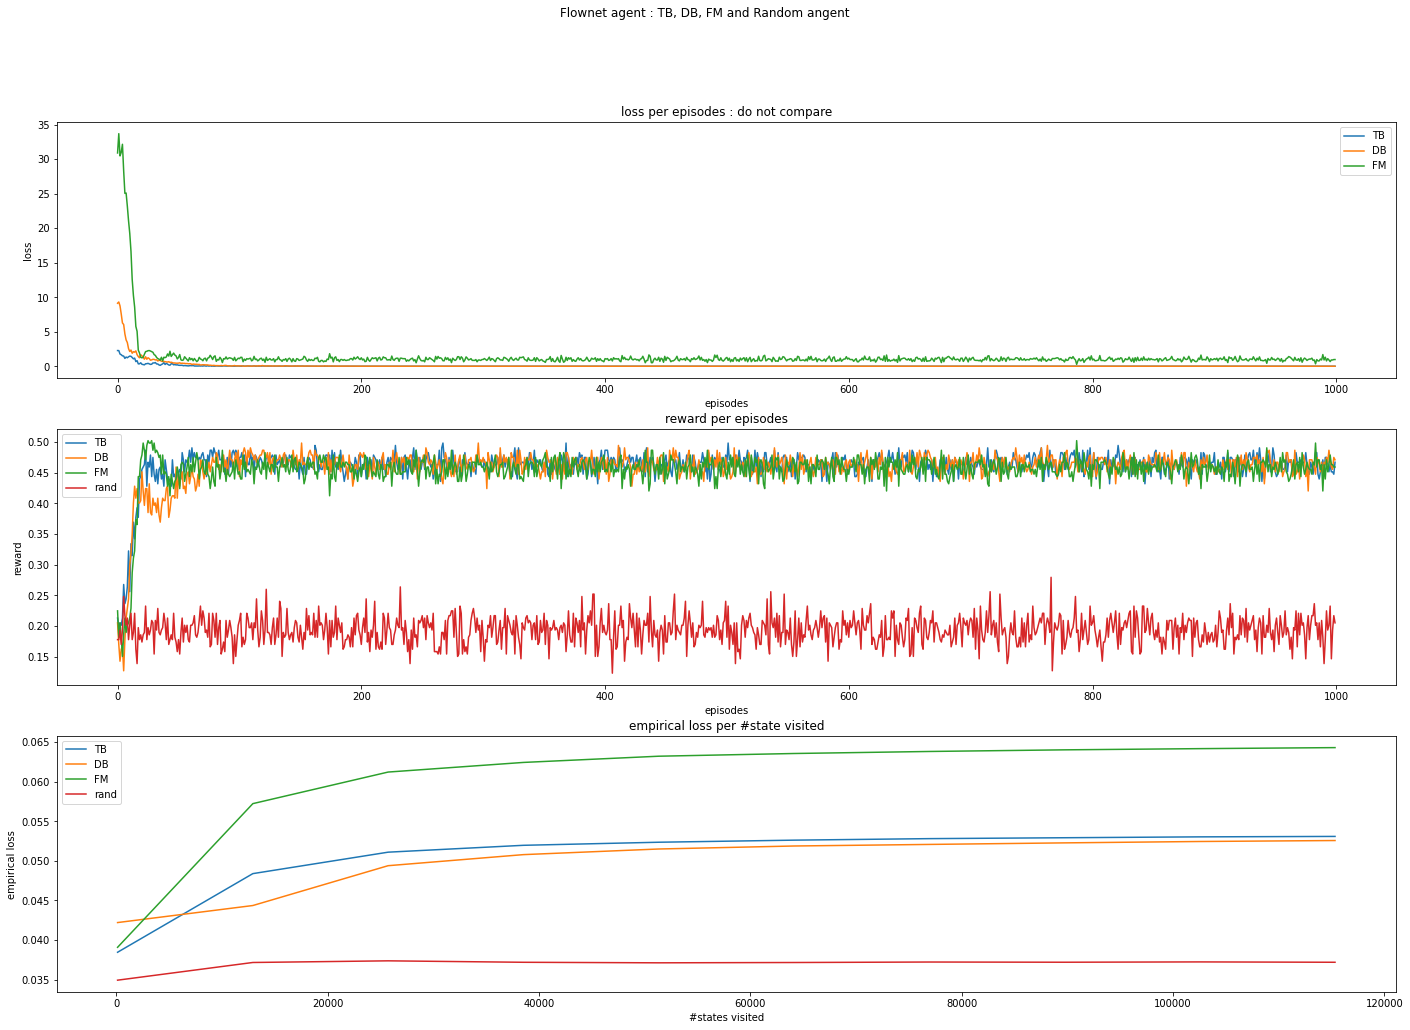

In [ ]:
figsize=(6*4,4*4)
#fig, (ax1, ax2, ax3, ax4)  = plt.subplots(4, 1, sharex=False, sharey=False, figsize = figsize)
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1, sharex=False, sharey=False, figsize = figsize)
fig.suptitle("Flownet agent : TB, DB, FM and Random angent")

## loss
xs_TB = list(range(len(losses_TB)))
ax1.plot(xs_TB, losses_TB, label="TB")
#-
xs_DB = list(range(len(losses_DB)))
ax1.plot(xs_DB, losses_DB, label="DB")
#-
xs_FM = list(range(len(losses_FM)))
ax1.plot(xs_FM, losses_FM, label="FM")
#-
ax1.set(xlabel='episodes', ylabel='loss')
ax1.set_title('loss per episodes : do not compare')
ax1.legend()

## rewards
ax2.plot(xs_TB, rewards_TB, label="TB")
ax2.plot(xs_DB, rewards_DB, label="DB")
ax2.plot(xs_FM, rewards_FM, label="FM")
ax2.plot(xs_TB, rewards_random, label="rand")
ax2.set(xlabel='episodes', ylabel='reward')
ax2.set_title('reward per episodes')
ax2.legend()

## empirical loss
xs = [a[0] for a in l1log_TB]
emp_loss_TB = [a[1] for a in l1log_TB]
ax3.plot(xs, emp_loss_TB, label="TB")
#-
xs = [a[0] for a in l1log_DB]
emp_loss_DB = [a[1] for a in l1log_DB]
ax3.plot(xs, emp_loss_DB, label="DB")
#-
xs = [a[0] for a in l1log_FM]
emp_loss_FM = [a[1] for a in l1log_FM]
ax3.plot(xs, emp_loss_FM, label="FM")
#-
xs = [a[0] for a in l1log_random]
emp_loss_random = [a[1] for a in l1log_random]
ax3.plot(xs, emp_loss_random, label="rand")
#-
ax3.set(xlabel='#states visited', ylabel='empirical loss')
ax3.set_title('empirical loss per #state visited')
ax3.legend()


## empiciral loss
"""
xs = list(range(len(emp_loss_TB)))
ax4.plot(xs, emp_loss_TB, label="TB")
#-
xs = list(range(len(emp_loss_DB)))
ax4.plot(xs, emp_loss_DB, label="DB")
#-
xs = list(range(len(emp_loss_FM)))
ax4.plot(xs, emp_loss_FM, label="FM")
#-
xs = list(range(len(emp_loss_random)))
ax4.plot(xs, emp_loss_random, label="rand")
#-
ax4.set(xlabel='#states visited', ylabel='empirical loss')
ax4.set_title('empirical loss per epoch')
ax4.legend()
"""



---



In [ ]:
#threshold = R1
threshold = R2
#max_steps = None
max_steps = 1000
modes_founds_TB_, xs_TB_ = get_modes_founds(first_visit_TB, threshold, max_steps)
modes_founds_DB_, xs_DB_ = get_modes_founds(first_visit_DB, threshold, max_steps)
modes_founds_FM_, xs_FM_ = get_modes_founds(first_visit_FM, threshold, max_steps)
modes_founds_random_, xs_random_ = get_modes_founds(first_visit_random, threshold, max_steps) 

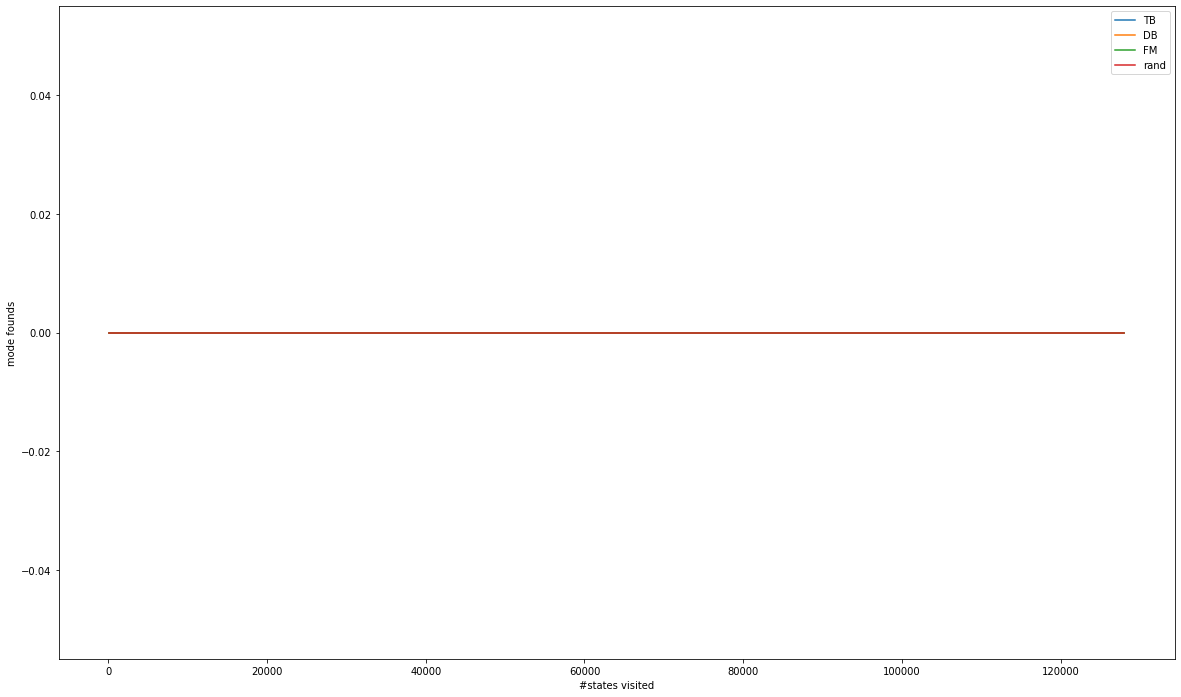

In [ ]:
figsize=(5*4,3*4)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

ax1.plot(xs_TB_, modes_founds_TB_, label="TB")
ax1.plot(xs_DB_, modes_founds_DB_, label="DB")
ax1.plot(xs_FM_, modes_founds_FM_, label="FM")
ax1.plot(xs_random_, modes_founds_random_, label="rand")
ax1.set(xlabel='#states visited', ylabel='mode founds')
#ax1.set_title('...')
ax1.legend()

# Load pretrained models and sample with



In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = torch.load("/content/data_gfn.pth", map_location=device)

Run the samples sections above